<font size="5">Fashion-MNIST Multilayer Perceptron (Tensorflow)</font>

**Version 1 - IN PROGRESS**

<u>Upcoming<u/>
- Improve Performance
  - Convert ndarrays to tensors for automatic differentiation support
  - Display performance metrics in confusion matrix; reduce error rate
  - Tune hyperparameters (learning rate/schedule, # layers, neurons per layer, neuron dropout, etc.)
- Reduce Computational Cost
  - Utilize 32-bit tensors for improved speed, minimized RAM usage
  - Implement Tensorboard callbacks for early stopping (plus visualization, statistics, etc.)

<br />

<u>Quick Notes<u/>
- Dataset contains 70,000 grayscale images of fashion items across 10 categories/classes, with information stored at the pixel level
  - Image dimensions are 28*28 pixels (784 total)
  - Data features consist of 784 pixel brightnesses (ranging from 0-255), with no colour (RGB/RGBA) information.
  - Data labels contain the true classification of each instance (integer encoding, 0-9).
- Since there is no emphasis on classifying any label in particular, and the full dataset conveniently includes equal proportions of all labels, train/validation/test sets are created with equal (stratified) proportions of instance labels.

In [1]:
#Imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from time import strftime
import datetime
import random

%load_ext tensorboard

In [2]:
#Import full CSV data as DataFrame
fmnist_full = pd.read_csv(r'C:\Users\darkw\Desktop\f_mnist_full.csv')
print(fmnist_full.shape)
pd.DataFrame(fmnist_full).head(2)

(70000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Establish indexed class list
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [4]:
#Sample 1: Visualize record stored in DataFrame
 #Select random df record
sample = fmnist_full.sample(1)
 #Output sample 1 category from df
s_class = sample['label'].values[0]
print('Item clothing category:', class_names[s_class])
 #Preview sample index+values
print(sample[['label','pixel18','pixel392','pixel750']])

Item clothing category: T-shirt/top
       label  pixel18  pixel392  pixel750
29191      0        0         0         0


In [5]:
 #Store sample features
sample = sample.drop(sample[['label']], axis=1)
s_vals = sample.values[0]
 #Reshape sample features for visualization
s_img = s_vals.reshape(28, 28)

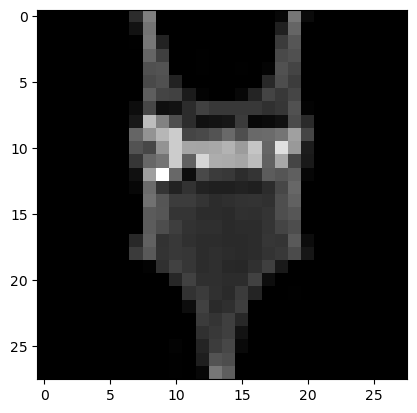

In [6]:
#Display sample in original cmap (grayscale)
plt.imshow(s_img, cmap='gray')

In [7]:
#Create target + feature dfs
y = fmnist_full['label']

X = fmnist_full.drop(fmnist_full[['label']], axis=1)
X.shape, y.shape

((70000, 784), (70000,))

In [8]:
#Review dataset balance
y.value_counts().sort_index()

label
0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
Name: count, dtype: int64

In [9]:
#Convert feature df to array + reshape for input layer
X_28 = X.to_numpy().reshape(70000, 28, 28)
X_28.shape

(70000, 28, 28)

In [10]:
#Convert target df to array
y = y.to_numpy()
y.shape

(70000,)

In [11]:
#Sample 2: Visualize record stored in array
 #Select random value for sample index
#index_val = random.randint(0, 70000)

 #locate initial df sample in new array by index
index_val = sample.index

 #Preview value
index_val

Index([29191], dtype='int64')

In [12]:
 #Output sample category from target array
s_class2 = y[index_val][0]

print('Item clothing category:', class_names[s_class2])

Item clothing category: T-shirt/top


In [13]:
 #Store sample values from reshaped array
sample2 = X_28[index_val][0]
 #Display integer values
print(sample2.dtype)
sample2[0][0:40]

int64


array([  0,   0,   0,   0,   0,   0,   0,  44, 127,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   7, 118,  10,   0,   0,   0,   0,   0,
         0,   0], dtype=int64)

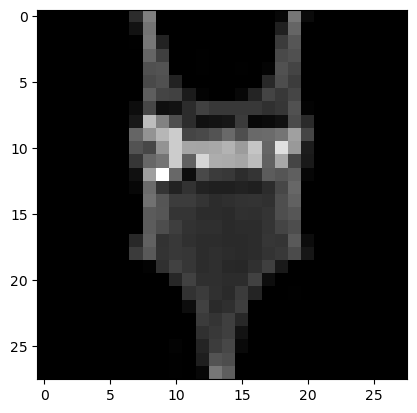

In [14]:
#Display sample 2 in original cmap (grayscale)
plt.imshow(sample2, cmap='gray')

In [15]:
#Split full dataset into 60,000 train + 10,000 test, maintaining label balance
X_train_full, X_te, y_train_full, y_te = train_test_split(X_28, y, test_size=1/7, stratify=y)

In [16]:
#Compare methods for creating validation set from training set
 #Keras training APIs include 'validation_split'; selects "the last samples in the x and y data provided, before shuffling"
  #Check last 5000 records to evaluate would-be balance of validation set created by index slice/keras method
y_last5k = y_train_full[-5000:]

In [17]:
value1, count1 = np.unique(y_last5k, return_counts=True)

last5k_dict = dict(map(lambda label, freq : (label,freq) , value1, count1))

for i in last5k_dict:
    print(i, last5k_dict[i])

0 507
1 491
2 544
3 483
4 476
5 494
6 507
7 488
8 526
9 484


In [18]:
#Split training data into 55,000 train + 5,000 validation
 #Use sklearn 'train_test_split' to stratify by label, preserving label balance more precisely than index slice/keras api
X_train, X_valid, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=1/12, stratify=y_train_full)

In [19]:
#Verify shapes
print(X_train.shape, y_tr.shape)
print(X_valid.shape, y_val.shape)
print(X_te.shape, y_te.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [20]:
#Verify balance
value2, count2 = np.unique(y_tr, return_counts=True)
value3, count3 = np.unique(y_val, return_counts=True)
value4, count4 = np.unique(y_te, return_counts=True)

In [21]:
 #Map and display dictionary for training label frequencies
label_dict1 = dict(map(lambda label, freq : (label,freq) , value2, count2))

for i in label_dict1:
    print(i, label_dict1[i])

0 5500
1 5500
2 5500
3 5500
4 5500
5 5500
6 5500
7 5500
8 5500
9 5500


In [22]:
 #Map and display dictionary for validation label frequencies
label_dict2 = dict(map(lambda label, freq : (label,freq) , value3, count3))

for i in label_dict2:
    print(i, label_dict2[i])

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [23]:
 #Map and display dictionary for test label frequencies
label_dict3 = dict(map(lambda label, freq : (label,freq) , value4, count4))

for i in label_dict3:
    print(i, label_dict3[i])

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


In [24]:
#Scale feature sets from 0-255 (int) to 0.0-1.0 (float)
X_tr_sc, X_val_sc, X_te_sc = X_train/255., X_valid/255., X_te/255.

In [25]:
#Visualize post-splits, post-scaling sample
sample3 = X_tr_sc[0]
#Verify transformation to float values
print(sample3.dtype)
sample3[0][0:40]

float64


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.29411765, 0.14901961, 0.14117647, 0.1372549 ,
       0.07843137, 0.10980392, 0.24705882, 0.03921569, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [26]:
s_class3 = y_tr[0]
print(class_names[s_class3])

Trouser


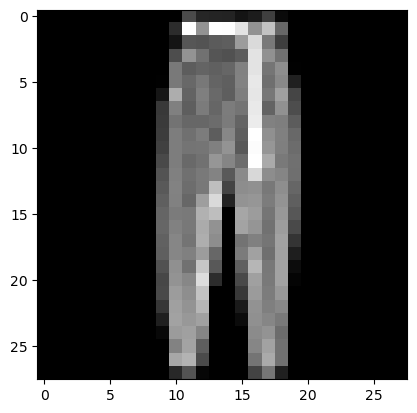

In [27]:
plt.imshow(sample3, cmap='gray')

In [28]:
#TensorBoard log directory setup
log_dir = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
event_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
#Build Network 1
 #2 Hidden layers (300 * 100 nodes)
dnn1 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(300, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Preview initialized weights and biases
layer_100node = dnn1.layers[2]
layer_100node.name

'dense_1'

In [31]:
weights_100, biases_100 = layer_100node.get_weights()
print(weights_100.shape)
weights_100

(300, 100)


array([[-0.06633005,  0.06656501, -0.01633751, ..., -0.0329575 ,
         0.06013011, -0.09096713],
       [-0.1045317 , -0.11061737, -0.05560263, ..., -0.01358025,
         0.0201325 , -0.03633167],
       [ 0.0132724 ,  0.08582223, -0.1040988 , ...,  0.11388726,
         0.03460059,  0.08844066],
       ...,
       [-0.05850612,  0.00114249, -0.04868656, ..., -0.10365499,
         0.10143081,  0.05088522],
       [-0.01864876, -0.04469259, -0.07847114, ..., -0.05352994,
         0.09143556, -0.01247184],
       [-0.00089183,  0.11207364, -0.01908536, ..., -0.03479072,
         0.09811186, -0.01293396]], dtype=float32)

In [32]:
print(biases_100.shape)
biases_100

(100,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [33]:
optimizer1 = tf.keras.optimizers.SGD() #set using 'learning_rate' (default: 0.01)

dnn1.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer1,
                   metrics=['accuracy'])

In [34]:
#Train network + store results
epoch_count = 25
history1 = dnn1.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=[event_cb])

Epoch 1/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7175 - accuracy: 0.7605 - val_loss: 0.5366 - val_accuracy: 0.8186
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4939 - accuracy: 0.8277 - val_loss: 0.4709 - val_accuracy: 0.8440
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4502 - accuracy: 0.8426 - val_loss: 0.4502 - val_accuracy: 0.8472
Epoch 4/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4220 - accuracy: 0.8523 - val_loss: 0.4247 - val_accuracy: 0.8556
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4029 - accuracy: 0.8595 - val_loss: 0.4348 - val_accuracy: 0.8470
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3836 - accuracy: 0.8658 - val_loss: 0.4132 - val_accuracy: 0.8492
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3705 - accuracy: 0.8702 - val_loss: 0.3936 - val_ac

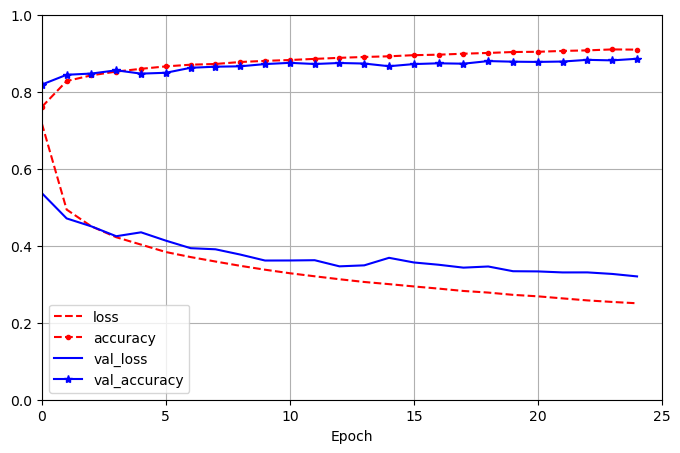

In [35]:
#Visualize learning curves manually
dnn1_learn_curves = pd.DataFrame(history1.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'])
plt.show()

In [36]:
#Evaluate model on test set
dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 1s 4ms/step - loss: 0.3007 - accuracy: 0.8929


[0.300741970539093, 0.8928999900817871]

In [37]:
#Display TensorBoard
%tensorboard --logdir tensorboard_logs/fit

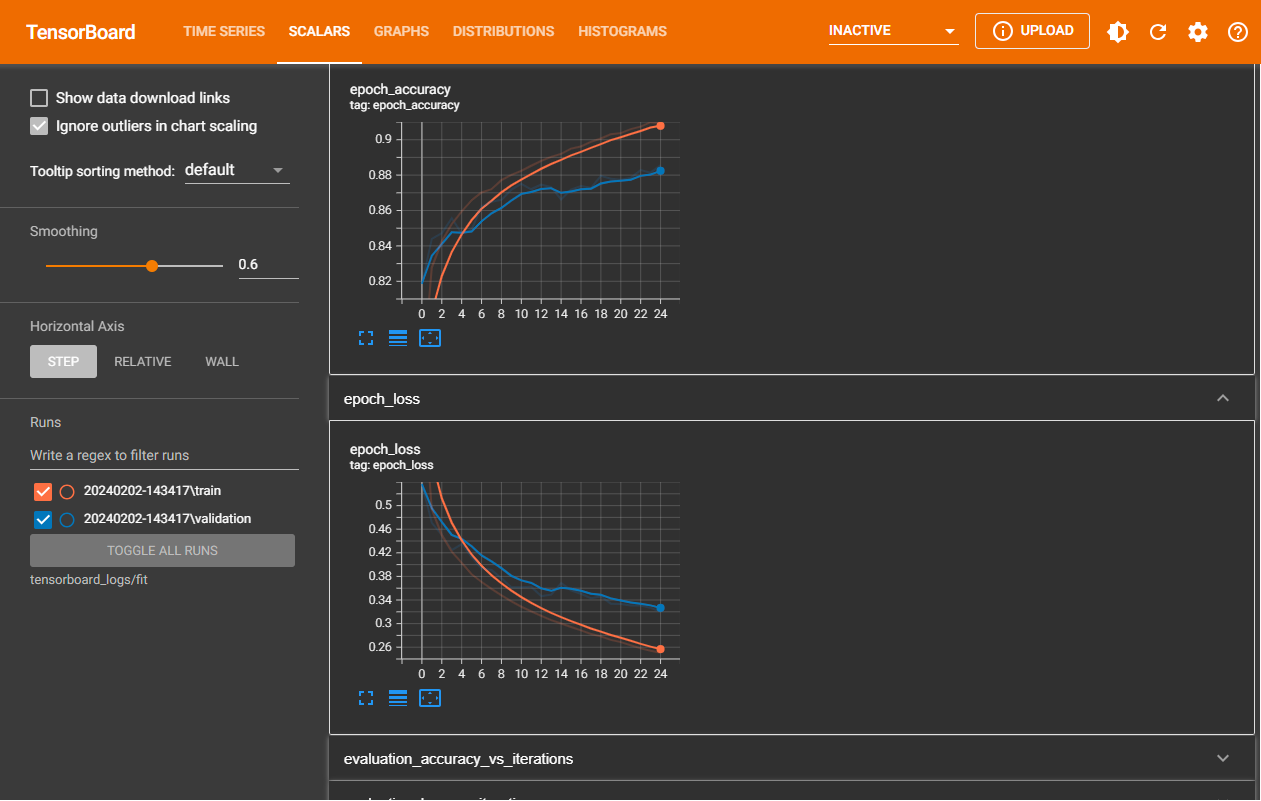